In [2]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime
import statistics

In [3]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"

# import data
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [182]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

zero_pledged = len(df1.loc[df1['usd_pledged'] == 0])
min_goal = min(list(df1['goal']))

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 5000)& (df1['usd_pledged'] > 100)]

df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')

In [183]:
print(len(df1))
print(len(df1_success))
print(len(df1_fail))
print(len(df1_success) / len(df1))
print()
print(zero_pledged)
print(min_goal)

46464
30586
15878
0.6582730716253443

19325
0.01


In [184]:
# first sort by category id, then sort by date
df1.sort_values(['deadline'], ascending = True, inplace = True)
df1_success.sort_values(['deadline'], ascending = True, inplace = True)
df1_fail.sort_values(['deadline'], ascending = True, inplace = True)

print(len(df1))
print(len(df1_success))
print(len(df1_fail))

46464
30586
15878


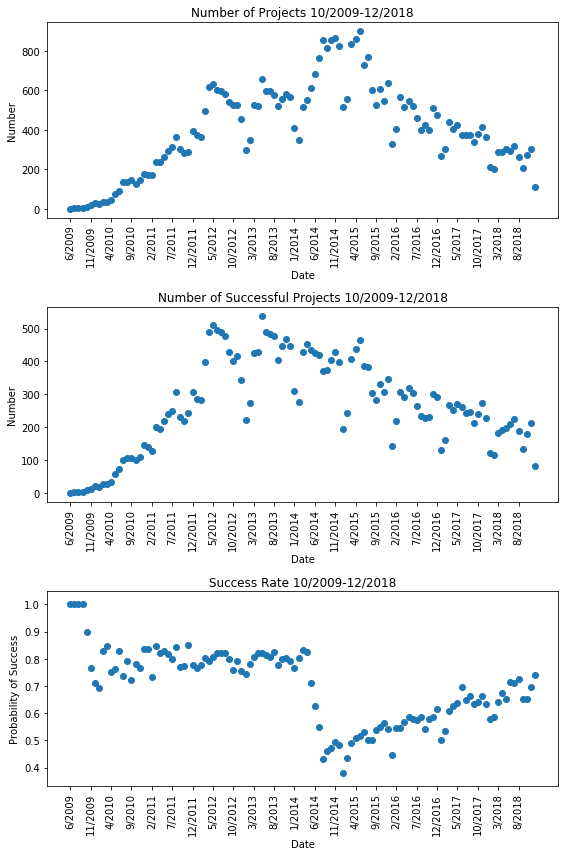

In [185]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

df2 = df1.copy()
# convert date to month/year format
df2['Month/Year'] = df2['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

# sort by date
df3 = df2.groupby(['Month/Year']).size().to_dict()
# holds all projects
ordered_df3 = sorted(df3.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)


# PLOT NUMBER OF PROJECTS
fig = plt.figure(figsize=(8, 12))

plt.subplot(3, 1, 1)
plt.scatter(*zip(*ordered_df3))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical') # plot every 5 months
plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Number of Projects 10/2009-12/2018')


# PLOT SUCCESS RATE

df2_success = df1_success.copy()
df2_success['Month/Year'] = df2_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

df3_success = df2_success.groupby(['Month/Year']).size().to_dict()
# holds all successful projects
ordered_df3_success = sorted(df3_success.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

ordered_df3_success_rate = []
# number of success per month / number of projects per month
for i in range(len(ordered_df3_success)):
    lst = list(ordered_df3_success[i])
    lst[1] = ordered_df3_success[i][1] / ordered_df3[i][1]
    ordered_df3_success_rate.append(tuple(lst))

plt.subplot(3, 1, 2)
plt.scatter(*zip(*ordered_df3_success))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Number of Successful Projects 10/2009-12/2018')
    
plt.subplot(3, 1, 3)
plt.scatter(*zip(*ordered_df3_success_rate))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Probability of Success')
plt.title('Success Rate 10/2009-12/2018')

plt.tight_layout()

plt.savefig(path3 + '/Monthy_project_number_vs_success.png')

{'2010': 1143, '2011': 3147, '2012': 5940, '2013': 6058, '2014': 7688, '2015': 7562, '2016': 5225, '2017': 4185, '2018': 2849}


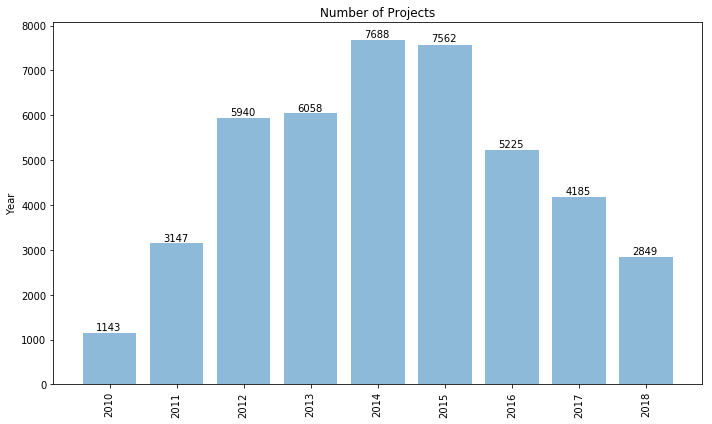

In [212]:
count = 0
temp = 0
year_dict = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in keys:
    year_dict[i] = 0

for i in range(8, len(ordered_df3) + 1):
    count += 1
    if count % 12 == 0:
        year_dict[keys[int(count / 12 - 1)]] = temp
        temp = 0
    else:
        temp += ordered_df3[i][1]
print(year_dict)

fig = plt.figure(figsize=(10, 6))

objects = tuple(year_dict.keys())
y_pos = np.arange(len(objects))
performance = list(year_dict.values())

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')

# Create labels
 
# Text on the top of each barplot
plt.text(x = -0.2 , y = 1200, s = performance[0], size = 10)
plt.text(x = 0.8 , y = 3200, s = performance[1], size = 10)
plt.text(x = 1.8 , y = 6000, s = performance[2], size = 10)
plt.text(x = 2.8 , y = 6100, s = performance[3], size = 10)
plt.text(x = 3.8 , y = 7750, s = performance[4], size = 10)
plt.text(x = 4.8 , y = 7650, s = performance[5], size = 10)
plt.text(x = 5.8 , y = 5300, s = performance[6], size = 10)
plt.text(x = 6.8 , y = 4250, s = performance[7], size = 10)
plt.text(x = 7.8 , y = 2900, s = performance[8], size = 10)


plt.ylabel('Number')
plt.ylabel('Year')
plt.title('Number of Projects')

plt.tight_layout()

plt.show()

{'2010': 892, '2011': 2539, '2012': 4738, '2013': 4879, '2014': 4421, '2015': 3894, '2016': 2998, '2017': 2665, '2018': 1927}


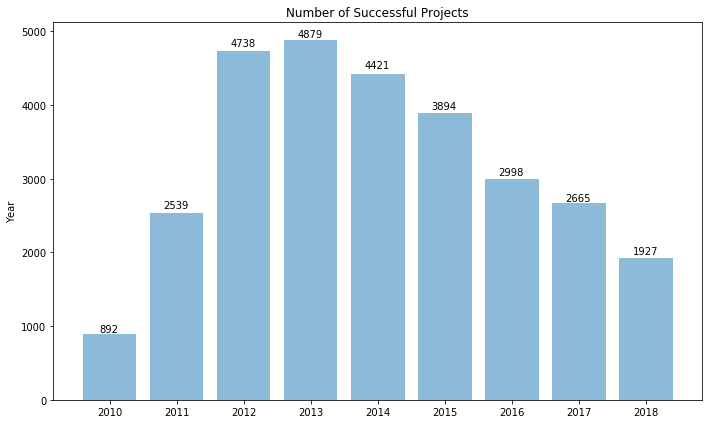

In [204]:
count = 0
temp = 0
year_dict = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in range(8, len(ordered_df3_success) + 1):
    count += 1
    if count % 12 == 0:
        year_dict[keys[int(count / 12 - 1)]] = temp
        temp = 0
    else:
        temp += ordered_df3_success[i][1]
print(year_dict)

fig = plt.figure(figsize=(10, 6))
y_pos = np.arange(len(keys))
performance = list(year_dict.values())
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, keys)

# Create labels
 
# Text on the top of each barplot
plt.text(x = -0.15 , y = 920, s = performance[0], size = 10)
plt.text(x = 0.8 , y = 2600, s = performance[1], size = 10)
plt.text(x = 1.8 , y = 4800, s = performance[2], size = 10)
plt.text(x = 2.8 , y = 4920, s = performance[3], size = 10)
plt.text(x = 3.8 , y = 4500, s = performance[4], size = 10)
plt.text(x = 4.8 , y = 3950, s = performance[5], size = 10)
plt.text(x = 5.8 , y = 3050, s = performance[6], size = 10)
plt.text(x = 6.8 , y = 2700, s = performance[7], size = 10)
plt.text(x = 7.8 , y = 1970, s = performance[8], size = 10)


plt.ylabel('Number')
plt.ylabel('Year')
plt.title('Number of Successful Projects')

plt.tight_layout()

plt.show()

In [211]:
# GOAL

df5_5000 = df1.copy()
df5_10000 = df5_5000.loc[df5_5000['goal'] > 10000]
df5_50000 = df5_5000.loc[df5_5000['goal'] > 50000]
df5_100000 = df5_5000.loc[df5_5000['goal'] > 100000]

print(len(df5_5000))
print(len(df5_10000))
print(len(df5_50000))
print(len(df5_100000))

46464
26876
4304
1531


5000
10000
15000
20000
25000
30000
35000
40000
45000
{'Goal': 0.9921648753660421, 'Pledged': 1.0386701005322203}


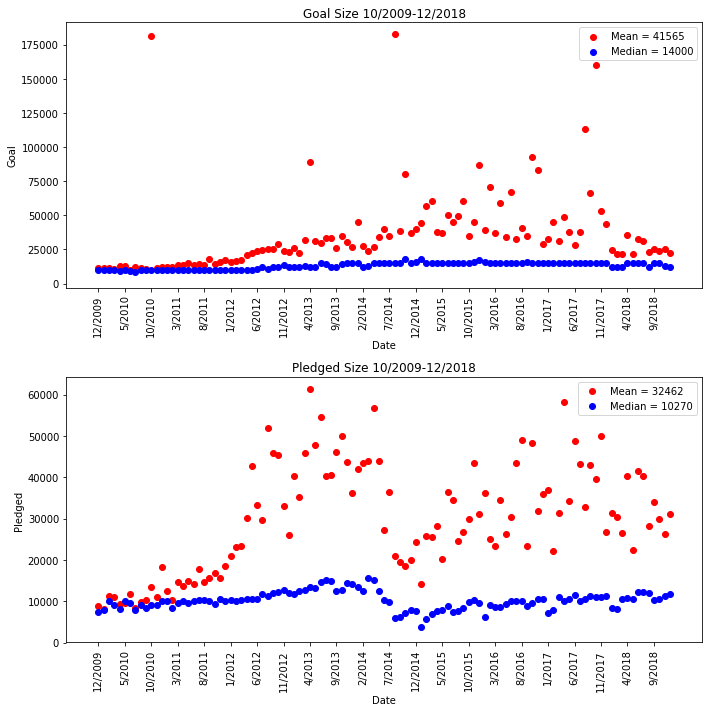

In [321]:
df4 = df1.copy()
df4['Month/Year'] = df4['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

# dictionary of month/Year as key and goal size as value
new_dict = dict()
count = 0
for i in df4['Month/Year']:
    temp = df4.loc[df4['Month/Year'] == i]
    new_dict[i] = temp['goal']
    count += 1
    if count % 5000 == 0:
        print(count)
    
avg_dict = {} # average goal size
median_dict = {} # median goal size
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 25: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)

ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

# PLOT GOAL SIZE

perc_diff = {}
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.scatter(*zip(*ordered_df4_1), color = 'red')
plt.scatter(*zip(*ordered_df4_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical') 
plt.xlabel('Date')
plt.ylabel('Goal')
mean1 = sum(df4['goal']) / len(df4['goal'])
med1 = statistics.median(df4['goal'])
plt.legend(['Mean = ' + str(round(mean1)), 
            'Median = ' + str(round(med1))])
plt.title('Goal Size 10/2009-12/2018')

perc_diff['Goal'] = (mean1 - med1) / ((mean1 + med1) / 2)

# PLOT PLEDGED SIZE

df5 = df1.copy()
df5['Month/Year'] = df5['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

# dictionary of month/Year as key and pledged size as value
new_dict1 = dict()
for i in df5['Month/Year']:
    temp = df5.loc[df5['Month/Year'] == i]
    new_dict1[i] = temp['usd_pledged']
    
avg_dict1 = {}
median_dict1 = {}
for k,v in new_dict1.items():
    avg = sum(v)/ len(v)
    if len(v) > 25:
        avg_dict1[k] = sum(v)/ len(v)
        median_dict1[k] = statistics.median(v)
    
ordered_df5_1 = sorted(avg_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df5_2 = sorted(median_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.subplot(2, 1, 2)
plt.scatter(*zip(*ordered_df5_1), color = 'red')
plt.scatter(*zip(*ordered_df5_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
mean2 = sum(df5['usd_pledged']) / len(df5['usd_pledged'])
med2 = statistics.median(df5['usd_pledged'])
plt.legend(['Mean = ' + str(round(sum(df5['usd_pledged']) / len(df5['usd_pledged']))), 
            'Median = ' + str(round(med2))])
plt.title('Pledged Size 10/2009-12/2018')

perc_diff['Pledged'] = (mean2 - med2) / ((mean2 + med2) / 2)

plt.tight_layout()

plt.savefig(path3 + 'Monthy_goal_size_vs_pledged_size.png')

print(perc_diff)


Text(0.5, 1.0, 'P/G 10/2009-12/2018')

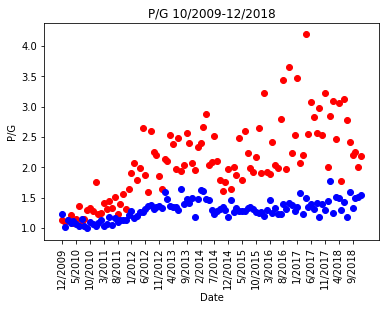

In [332]:
dict_pg1 = {}
dict_pg2 = {}
for i in range(len(ordered_df4_success_1)):
    dict_pg1[ordered_df4_success_1[i][0]] = ordered_df5_success_1[i][1] / ordered_df4_success_1[i][1]
    dict_pg2[ordered_df4_success_2[i][0]] = ordered_df5_success_2[i][1] / ordered_df4_success_2[i][1]
    
ordered_df6_1 = sorted(dict_pg1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df6_2 = sorted(dict_pg2.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
    
plt.scatter(*zip(*ordered_df6_1), color = 'red')
plt.scatter(*zip(*ordered_df6_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('P/G')
plt.title('P/G 10/2009-12/2018')

Text(0.5, 1.0, 'P/G 10/2009-12/2018')

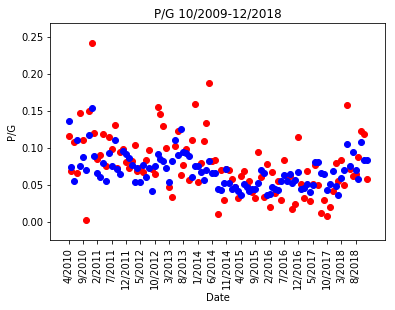

In [333]:
dict_pg1 = {}
dict_pg2 = {}
for i in range(len(ordered_df4_fail_1)):
    dict_pg1[ordered_df4_fail_1[i][0]] = ordered_df5_fail_1[i][1] / ordered_df4_fail_1[i][1]
    dict_pg2[ordered_df4_fail_2[i][0]] = ordered_df5_fail_2[i][1] / ordered_df4_fail_2[i][1]
    
ordered_df6_1 = sorted(dict_pg1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df6_2 = sorted(dict_pg2.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
    
plt.scatter(*zip(*ordered_df6_1), color = 'red')
plt.scatter(*zip(*ordered_df6_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('P/G')
plt.title('P/G 10/2009-12/2018')

In [230]:
print('Average goal size: ')
print(sum(df4['goal']) / len(df4['goal']))
# $97,567
print('Median goal size: ')
print(statistics.median(df4['goal']))
# $50,000
print('Average pledged size: ')
print(sum(df5['usd_pledged']) / len(df5['usd_pledged']))
# $120,310
print('Median pledged size: ')
print(statistics.median(df5['usd_pledged']))
# $44,131

Average goal size: 
41564.64408832645
Median goal size: 
14000.0
Average pledged size: 
32462.468867079962
Median pledged size: 
10270.0


{'Successful Goal': 0.5616630663153238, 'Successful Pledged': 1.0104611538329005, 'Failed Goal': 1.2036809129111348, 'Failed Pledged': 1.088793063664882}


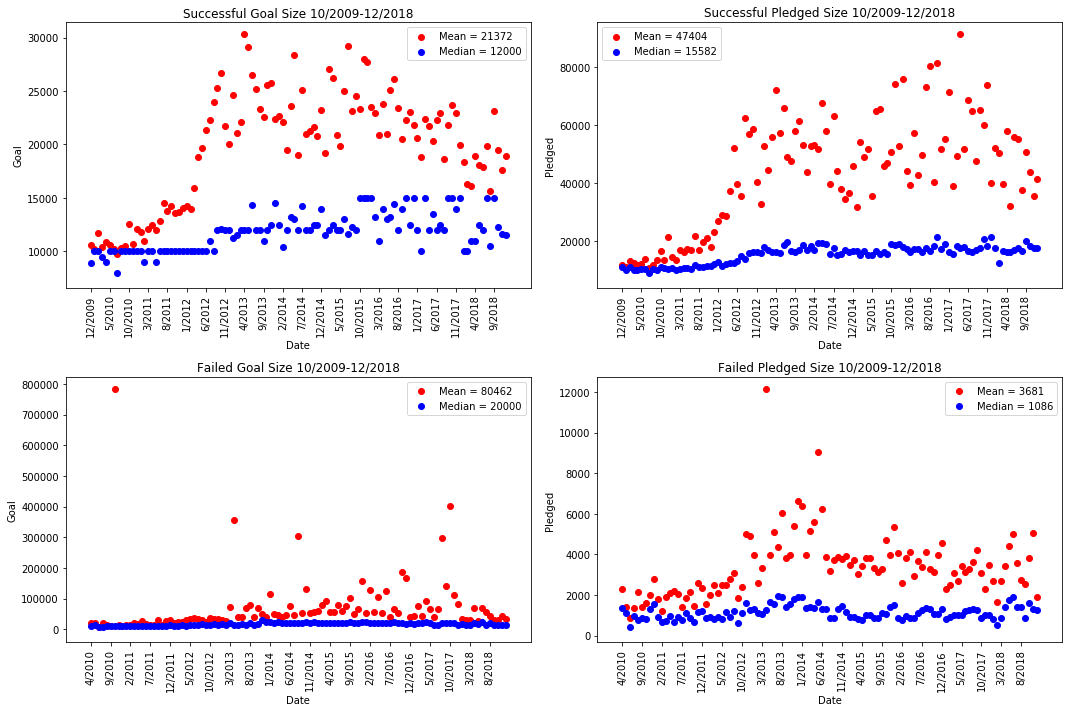

In [328]:
# same as previous approach except using dataframe of only successful or failed projects

df4_success = df1_success.copy()
df4_success['Month/Year'] = df4_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4_success['Month/Year']:
    temp = df4_success.loc[df4_success['Month/Year'] == i]
    new_dict[i] = temp['goal']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 15: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_success_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_success_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

# PLOT SUCCESSFUL GOAL SIZE

perc_diff = {}
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)

plt.scatter(*zip(*ordered_df4_success_1), color = 'red')
plt.scatter(*zip(*ordered_df4_success_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical') 
plt.xlabel('Date')
plt.ylabel('Goal')
mean1 = sum(df4_success['goal']) / len(df4_success['goal'])
med1 = statistics.median(df4_success['goal'])
plt.legend(['Mean = ' + str(round(mean1)), 
            'Median = ' + str(round(med1))])
plt.title('Successful Goal Size 10/2009-12/2018')

perc_diff['Successful Goal'] = (mean1 - med1) / ((mean1 + med1) / 2)

# PLOT SUCCESSFUL PLEDGED SIZE
plt.subplot(2, 2, 2)

df5_success = df1_success.copy()
df5_success['Month/Year'] = df5_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict1 = dict()
for i in df5_success['Month/Year']:
    temp = df5_success.loc[df5_success['Month/Year'] == i]
    new_dict1[i] = temp['usd_pledged']
    
avg_dict1 = {}
median_dict1 = {}
for k,v in new_dict1.items():
    avg = sum(v)/ len(v)
    if len(v) > 15: # significant enough number of projects
        avg_dict1[k] = sum(v)/ len(v)
        median_dict1[k] = statistics.median(v)
    
ordered_df5_success_1 = sorted(avg_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df5_success_2 = sorted(median_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df5_success_1), color = 'red')
plt.scatter(*zip(*ordered_df5_success_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
mean2 = sum(df5_success['usd_pledged']) / len(df5_success['usd_pledged'])
med2 = statistics.median(df5_success['usd_pledged'])
plt.legend(['Mean = ' + str(round(mean2)), 
            'Median = ' + str(round(med2))])
plt.title('Successful Pledged Size 10/2009-12/2018')

perc_diff['Successful Pledged'] = (mean2 - med2) / ((mean2 + med2) / 2)

# PLOT FAILED GOAL SIZE
plt.subplot(2, 2, 3)

df4_fail = df1_fail.copy()
df4_fail['Month/Year'] = df4_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict2 = dict()
for i in df4_fail['Month/Year']:
    temp = df4_fail.loc[df4_fail['Month/Year'] == i]
    new_dict2[i] = temp['goal']
    
avg_dict2 = {}
median_dict2 = {}
for k,v in new_dict2.items():
    avg = sum(v)/ len(v)
    if len(v) > 10: # significant enough number of projects
        avg_dict2[k] = sum(v)/ len(v)
        median_dict2[k] = statistics.median(v)
    
ordered_df4_fail_1 = sorted(avg_dict2.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_fail_2 = sorted(median_dict2.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_fail_1), color = 'red')
plt.scatter(*zip(*ordered_df4_fail_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Goal')
mean3 = sum(df4_fail['goal']) / len(df4_fail['goal'])
med3 = statistics.median(df4_fail['goal'])
plt.legend(['Mean = ' + str(round(mean3)), 
            'Median = ' + str(round(med3))])
plt.title('Failed Goal Size 10/2009-12/2018')

perc_diff['Failed Goal'] = (mean3 - med3) / ((mean3 + med3) / 2)

# PLOT FAILED PLEDGED SIZE

plt.subplot(2, 2, 4)
df5_fail = df1_fail.copy()
df5_fail['Month/Year'] = df5_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict3 = dict()
for i in df5_fail['Month/Year']:
    temp = df5_fail.loc[df5_fail['Month/Year'] == i]
    new_dict3[i] = temp['usd_pledged']
    
avg_dict3 = {}
median_dict3 = {}
for k,v in new_dict3.items():
    avg = sum(v)/ len(v)
    if len(v) > 10: # significant enough number of projects
        avg_dict3[k] = sum(v)/ len(v)
        median_dict3[k] = statistics.median(v)
    
ordered_df5_fail_1 = sorted(avg_dict3.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df5_fail_2 = sorted(median_dict3.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df5_fail_1), color = 'red')
plt.scatter(*zip(*ordered_df5_fail_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
mean4 = sum(df5_fail['usd_pledged']) / len(df5_fail['usd_pledged'])
med4 = statistics.median(df5_fail['usd_pledged'])
plt.legend(['Mean = ' + str(round(mean4)), 
            'Median = ' + str(round(med4))])
plt.title('Failed Pledged Size 10/2009-12/2018')

perc_diff['Failed Pledged'] = (mean4 - med4) / ((mean4 + med4) / 2)

plt.tight_layout()

plt.savefig(path3 + 'Monthy_goal_size_vs_pledged_size_successful_vs_fail.png')

print(perc_diff)

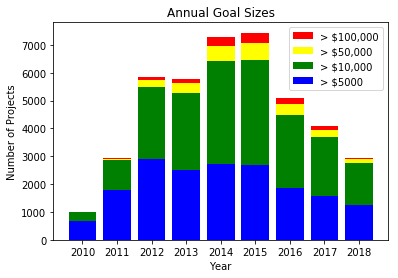

In [334]:
df4 = df1.copy()
df4['Month/Year'] = df4['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

new_dict = dict()
for i in df4['Month/Year']:
    temp = df4.loc[df4['Month/Year'] == i]
    new_dict[i] = list(temp['goal'])

new_dict_5000 = dict()
new_dict_10000 = dict()
new_dict_50000 = dict()
new_dict_100000 = dict()
for i in df4['Month/Year']:
    new_dict_5000[i] = 0
    new_dict_10000[i] = 0
    new_dict_50000[i] = 0
    new_dict_100000[i] = 0
    
for k,v in new_dict.items():
    for i in v:
        if i > 5000:
            new_dict_5000[k] += 1
        if i > 10000:
            new_dict_10000[k] += 1
        if i > 50000:
            new_dict_50000[k] += 1
        if i > 100000:
            new_dict_100000[k] += 1
            
year_dict_5000 = {}
year_dict_10000 = {}
year_dict_50000 = {}
year_dict_100000 = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in keys:
    year_dict_5000[i] = 0
    year_dict_10000[i] = 0
    year_dict_50000[i] = 0
    year_dict_100000[i] = 0
temp = 0
count = 0
for i in range(7, len(new_dict_5000)):
    count += 1
    if count % 12 == 0:
        year_dict_5000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_5000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_10000)):
    count += 1
    if count % 12 == 0:
        year_dict_10000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_10000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_50000)):
    count += 1
    if count % 12 == 0:
        year_dict_50000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_50000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_100000)):
    count += 1
    if count % 12 == 0:
        year_dict_100000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_100000.values())
        temp += lst[i]
            
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

lst_5000 = []
lst_10000 = []
lst_50000 = []
lst_100000 = []
for i in years:
    lst_5000.append(year_dict_5000[i] - year_dict_10000[i])
    lst_10000.append(year_dict_10000[i] - year_dict_50000[i])
    lst_50000.append(year_dict_50000[i] - year_dict_100000[i])
    lst_100000.append(year_dict_100000[i])

bronzes = np.array(lst_5000)
silvers = np.array(lst_10000)
golds = np.array(lst_50000)
diamonds = np.array(lst_100000)
ind = [x for x, _ in enumerate(years)]

plt.bar(ind, diamonds, width=0.8, label='> $100,000', color='red', bottom=silvers+bronzes+golds)
plt.bar(ind, golds, width=0.8, label='> $50,000', color='yellow', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.8, label='> $10,000', color='green', bottom=bronzes)
plt.bar(years, bronzes, width=0.8, label='> $5000', color='blue')

plt.xticks(ind, years)
plt.ylabel("Number of Projects")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.title("Annual Goal Sizes")

plt.show()

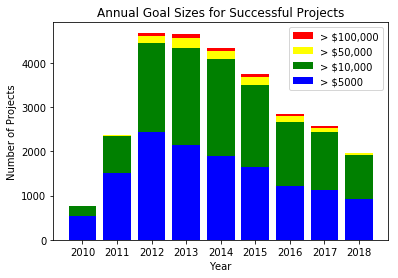

In [341]:
df4_success = df1_success.copy()
df4_success['Month/Year'] = df4_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

new_dict = dict()
for i in df4_success['Month/Year']:
    temp = df4_success.loc[df4_success['Month/Year'] == i]
    new_dict[i] = list(temp['goal'])

new_dict_5000 = dict()
new_dict_10000 = dict()
new_dict_50000 = dict()
new_dict_100000 = dict()
for i in df4_success['Month/Year']:
    new_dict_5000[i] = 0
    new_dict_10000[i] = 0
    new_dict_50000[i] = 0
    new_dict_100000[i] = 0
    
for k,v in new_dict.items():
    for i in v:
        if i > 5000:
            new_dict_5000[k] += 1
        if i > 10000:
            new_dict_10000[k] += 1
        if i > 50000:
            new_dict_50000[k] += 1
        if i > 100000:
            new_dict_100000[k] += 1
            
year_dict_5000 = {}
year_dict_10000 = {}
year_dict_50000 = {}
year_dict_100000 = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in keys:
    year_dict_5000[i] = 0
    year_dict_10000[i] = 0
    year_dict_50000[i] = 0
    year_dict_100000[i] = 0
temp = 0
count = 0
for i in range(7, len(new_dict_5000)):
    count += 1
    if count % 12 == 0:
        year_dict_5000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_5000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_10000)):
    count += 1
    if count % 12 == 0:
        year_dict_10000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_10000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_50000)):
    count += 1
    if count % 12 == 0:
        year_dict_50000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_50000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_100000)):
    count += 1
    if count % 12 == 0:
        year_dict_100000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_100000.values())
        temp += lst[i]
            
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

lst_5000 = []
lst_10000 = []
lst_50000 = []
lst_100000 = []
for i in years:
    lst_5000.append(year_dict_5000[i] - year_dict_10000[i])
    lst_10000.append(year_dict_10000[i] - year_dict_50000[i])
    lst_50000.append(year_dict_50000[i] - year_dict_100000[i])
    lst_100000.append(year_dict_100000[i])

bronzes = np.array(lst_5000)
silvers = np.array(lst_10000)
golds = np.array(lst_50000)
diamonds = np.array(lst_100000)
ind = [x for x, _ in enumerate(years)]

plt.bar(ind, diamonds, width=0.8, label='> $100,000', color='red', bottom=silvers+bronzes+golds)
plt.bar(ind, golds, width=0.8, label='> $50,000', color='yellow', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.8, label='> $10,000', color='green', bottom=bronzes)
plt.bar(years, bronzes, width=0.8, label='> $5000', color='blue')

plt.xticks(ind, years)
plt.ylabel("Number of Projects")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.title("Annual Goal Sizes for Successful Projects")

plt.show()

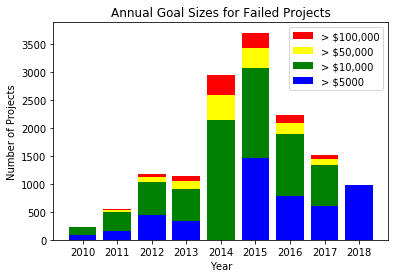

In [340]:
df4_fail = df1_fail.copy()
df4_fail['Month/Year'] = df4_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

new_dict = dict()
for i in df4_fail['Month/Year']:
    temp = df4_fail.loc[df4_fail['Month/Year'] == i]
    new_dict[i] = list(temp['goal'])

new_dict_5000 = dict()
new_dict_10000 = dict()
new_dict_50000 = dict()
new_dict_100000 = dict()
for i in df4_fail['Month/Year']:
    new_dict_5000[i] = 0
    new_dict_10000[i] = 0
    new_dict_50000[i] = 0
    new_dict_100000[i] = 0
    
for k,v in new_dict.items():
    for i in v:
        if i > 5000:
            new_dict_5000[k] += 1
        if i > 10000:
            new_dict_10000[k] += 1
        if i > 50000:
            new_dict_50000[k] += 1
        if i > 100000:
            new_dict_100000[k] += 1
            
year_dict_5000 = {}
year_dict_10000 = {}
year_dict_50000 = {}
year_dict_100000 = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in keys:
    year_dict_5000[i] = 0
    year_dict_10000[i] = 0
    year_dict_50000[i] = 0
    year_dict_100000[i] = 0
temp = 0
count = 0
for i in range(3, len(new_dict_5000)):
    count += 1
    if count % 12 == 0:
        year_dict_5000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_5000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_10000)):
    count += 1
    if count % 12 == 0:
        year_dict_10000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_10000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_50000)):
    count += 1
    if count % 12 == 0:
        year_dict_50000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_50000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_100000)):
    count += 1
    if count % 12 == 0:
        year_dict_100000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_100000.values())
        temp += lst[i]
            
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

lst_5000 = []
lst_10000 = []
lst_50000 = []
lst_100000 = []
for i in years:
    lst_5000.append(year_dict_5000[i] - year_dict_10000[i])
    lst_10000.append(year_dict_10000[i] - year_dict_50000[i])
    lst_50000.append(year_dict_50000[i] - year_dict_100000[i])
    lst_100000.append(year_dict_100000[i])

bronzes = np.array(lst_5000)
silvers = np.array(lst_10000)
golds = np.array(lst_50000)
diamonds = np.array(lst_100000)
ind = [x for x, _ in enumerate(years)]

plt.bar(ind, diamonds, width=0.8, label='> $100,000', color='red', bottom=silvers+bronzes+golds)
plt.bar(ind, golds, width=0.8, label='> $50,000', color='yellow', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.8, label='> $10,000', color='green', bottom=bronzes)
plt.bar(years, bronzes, width=0.8, label='> $5000', color='blue')

plt.xticks(ind, years)
plt.ylabel("Number of Projects")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.title("Annual Goal Sizes for Failed Projects")

plt.show()

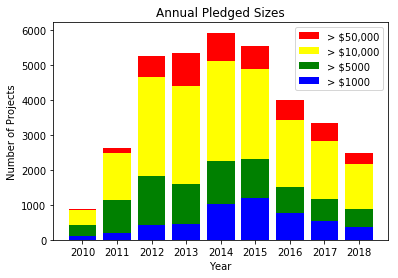

In [337]:
df4 = df1.copy()
df4['Month/Year'] = df4['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

new_dict = dict()
for i in df4['Month/Year']:
    temp = df4.loc[df4['Month/Year'] == i]
    new_dict[i] = list(temp['usd_pledged'])

new_dict_1000 = dict()
new_dict_5000 = dict()
new_dict_10000 = dict()
new_dict_50000 = dict()
for i in df4['Month/Year']:
    new_dict_1000[i] = 0
    new_dict_5000[i] = 0
    new_dict_10000[i] = 0
    new_dict_50000[i] = 0
    
for k,v in new_dict.items():
    for i in v:
        if i > 1000:
            new_dict_1000[k] += 1
        if i > 5000:
            new_dict_5000[k] += 1
        if i > 10000:
            new_dict_10000[k] += 1
        if i > 50000:
            new_dict_50000[k] += 1
            
year_dict_1000 = {}
year_dict_5000 = {}
year_dict_10000 = {}
year_dict_50000 = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in keys:
    year_dict_1000[i] = 0
    year_dict_5000[i] = 0
    year_dict_10000[i] = 0
    year_dict_50000[i] = 0
temp = 0
count = 0
for i in range(7, len(new_dict_1000)):
    count += 1
    if count % 12 == 0:
        year_dict_1000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_1000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_5000)):
    count += 1
    if count % 12 == 0:
        year_dict_5000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_5000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_10000)):
    count += 1
    if count % 12 == 0:
        year_dict_10000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_10000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_50000)):
    count += 1
    if count % 12 == 0:
        year_dict_50000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_50000.values())
        temp += lst[i]
            
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

lst_1000 = []
lst_5000 = []
lst_10000 = []
lst_50000 = []
for i in years:
    lst_1000.append(year_dict_1000[i] - year_dict_5000[i])
    lst_5000.append(year_dict_5000[i] - year_dict_10000[i])
    lst_10000.append(year_dict_10000[i] - year_dict_50000[i])
    lst_50000.append(year_dict_50000[i])

bronzes = np.array(lst_1000)
silvers = np.array(lst_5000)
golds = np.array(lst_10000)
diamonds = np.array(lst_50000)
ind = [x for x, _ in enumerate(years)]

plt.bar(ind, diamonds, width=0.8, label='> $50,000', color='red', bottom=silvers+bronzes+golds)
plt.bar(ind, golds, width=0.8, label='> $10,000', color='yellow', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.8, label='> $5000', color='green', bottom=bronzes)
plt.bar(years, bronzes, width=0.8, label='> $1000', color='blue')

plt.xticks(ind, years)
plt.ylabel("Number of Projects")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.title("Annual Pledged Sizes")

plt.show()

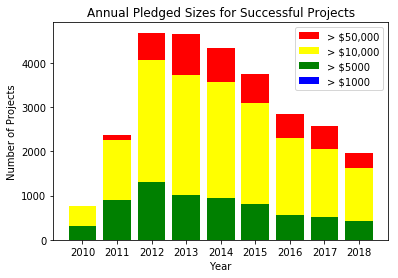

In [338]:
df4_success = df1_success.copy()
df4_success['Month/Year'] = df4_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

new_dict = dict()
for i in df4_success['Month/Year']:
    temp = df4_success.loc[df4_success['Month/Year'] == i]
    new_dict[i] = list(temp['usd_pledged'])

new_dict_1000 = dict()
new_dict_5000 = dict()
new_dict_10000 = dict()
new_dict_50000 = dict()
for i in df4_success['Month/Year']:
    new_dict_1000[i] = 0
    new_dict_5000[i] = 0
    new_dict_10000[i] = 0
    new_dict_50000[i] = 0
    
for k,v in new_dict.items():
    for i in v:
        if i > 1000:
            new_dict_1000[k] += 1
        if i > 5000:
            new_dict_5000[k] += 1
        if i > 10000:
            new_dict_10000[k] += 1
        if i > 50000:
            new_dict_50000[k] += 1
            
year_dict_1000 = {}
year_dict_5000 = {}
year_dict_10000 = {}
year_dict_50000 = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in keys:
    year_dict_1000[i] = 0
    year_dict_5000[i] = 0
    year_dict_10000[i] = 0
    year_dict_50000[i] = 0
temp = 0
count = 0
for i in range(7, len(new_dict_1000)):
    count += 1
    if count % 12 == 0:
        year_dict_1000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_1000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_5000)):
    count += 1
    if count % 12 == 0:
        year_dict_5000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_5000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_10000)):
    count += 1
    if count % 12 == 0:
        year_dict_10000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_10000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_50000)):
    count += 1
    if count % 12 == 0:
        year_dict_50000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_50000.values())
        temp += lst[i]
            
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

lst_1000 = []
lst_5000 = []
lst_10000 = []
lst_50000 = []
for i in years:
    lst_1000.append(year_dict_1000[i] - year_dict_5000[i])
    lst_5000.append(year_dict_5000[i] - year_dict_10000[i])
    lst_10000.append(year_dict_10000[i] - year_dict_50000[i])
    lst_50000.append(year_dict_50000[i])

bronzes = np.array(lst_1000)
silvers = np.array(lst_5000)
golds = np.array(lst_10000)
diamonds = np.array(lst_50000)
ind = [x for x, _ in enumerate(years)]

plt.bar(ind, diamonds, width=0.8, label='> $50,000', color='red', bottom=silvers+bronzes+golds)
plt.bar(ind, golds, width=0.8, label='> $10,000', color='yellow', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.8, label='> $5000', color='green', bottom=bronzes)
plt.bar(years, bronzes, width=0.8, label='> $1000', color='blue')

plt.xticks(ind, years)
plt.ylabel("Number of Projects")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.title("Annual Pledged Sizes for Successful Projects")

plt.show()

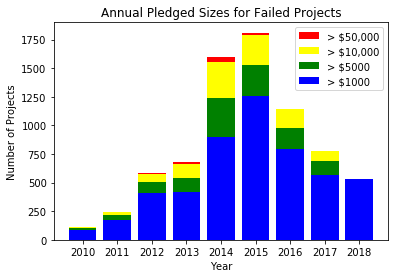

In [339]:
df4_fail = df1_fail.copy()
df4_fail['Month/Year'] = df4_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

new_dict = dict()
for i in df4_fail['Month/Year']:
    temp = df4_fail.loc[df4_fail['Month/Year'] == i]
    new_dict[i] = list(temp['usd_pledged'])

new_dict_1000 = dict()
new_dict_5000 = dict()
new_dict_10000 = dict()
new_dict_50000 = dict()
for i in df4_fail['Month/Year']:
    new_dict_1000[i] = 0
    new_dict_5000[i] = 0
    new_dict_10000[i] = 0
    new_dict_50000[i] = 0
    
for k,v in new_dict.items():
    for i in v:
        if i > 1000:
            new_dict_1000[k] += 1
        if i > 5000:
            new_dict_5000[k] += 1
        if i > 10000:
            new_dict_10000[k] += 1
        if i > 50000:
            new_dict_50000[k] += 1
            
year_dict_1000 = {}
year_dict_5000 = {}
year_dict_10000 = {}
year_dict_50000 = {}
keys = ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
for i in keys:
    year_dict_1000[i] = 0
    year_dict_5000[i] = 0
    year_dict_10000[i] = 0
    year_dict_50000[i] = 0
temp = 0
count = 0
for i in range(3, len(new_dict_1000)):
    count += 1
    if count % 12 == 0:
        year_dict_1000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_1000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_5000)):
    count += 1
    if count % 12 == 0:
        year_dict_5000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_5000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_10000)):
    count += 1
    if count % 12 == 0:
        year_dict_10000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_10000.values())
        temp += lst[i]
temp = 0
count = 0
for i in range(7, len(new_dict_50000)):
    count += 1
    if count % 12 == 0:
        year_dict_50000[keys[int(count / 12) - 1]] = temp
        temp = 0
    else:
        lst = list(new_dict_50000.values())
        temp += lst[i]
            
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

lst_1000 = []
lst_5000 = []
lst_10000 = []
lst_50000 = []
for i in years:
    lst_1000.append(year_dict_1000[i] - year_dict_5000[i])
    lst_5000.append(year_dict_5000[i] - year_dict_10000[i])
    lst_10000.append(year_dict_10000[i] - year_dict_50000[i])
    lst_50000.append(year_dict_50000[i])

bronzes = np.array(lst_1000)
silvers = np.array(lst_5000)
golds = np.array(lst_10000)
diamonds = np.array(lst_50000)
ind = [x for x, _ in enumerate(years)]

plt.bar(ind, diamonds, width=0.8, label='> $50,000', color='red', bottom=silvers+bronzes+golds)
plt.bar(ind, golds, width=0.8, label='> $10,000', color='yellow', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.8, label='> $5000', color='green', bottom=bronzes)
plt.bar(years, bronzes, width=0.8, label='> $1000', color='blue')

plt.xticks(ind, years)
plt.ylabel("Number of Projects")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.title("Annual Pledged Sizes for Failed Projects")

plt.show()

In [237]:
print('Pledged:Goal Ratio for Successful projects')
success_goal = list(df4_success['goal'])
success_pledged = list(df5_success['usd_pledged'])

pg1 = []
for i in range(len(df4_success)):
    pg1.append(success_pledged[i] / success_goal[i])
    
print('Average = ' + str(sum(pg1) / len(pg1)))
print('Median = ' + str(statistics.median(pg1)))

print()

print('Pledged:Goal Ratio for Failed projects')
fail_goal = list(df4_fail['goal'])
fail_pledged = list(df5_fail['usd_pledged'])

pg2 = []
for i in range(len(df4_fail)):
    pg2.append(fail_pledged[i] / fail_goal[i])
    
print('Average = ' + str(sum(pg2) / len(pg2)))
print('Median = ' + str(statistics.median(pg2)))

Pledged:Goal Ratio for Successful projects
Average = 1.9092984035358043
Median = 1.1237071428571428

Pledged:Goal Ratio for Failed projects
Average = 0.13113911040994244
Median = 0.0595


In [238]:
# results from graph for reference

print('Average successful goal size: ')
print(sum(df4_success['goal']) / len(df4_success['goal']))
# $66,087
print('Median successful goal size: ')
print(statistics.median(df4_success['goal']))
# $45,000

print('Average successful pledged size: ')
print(sum(df5_success['usd_pledged']) / len(df5_success['usd_pledged']))
# $166,866
print('Median successful pledged size: ')
print(statistics.median(df5_success['usd_pledged']))
# $61,685

print('Average failed goal size: ')
print(sum(df4_fail['goal']) / len(df4_fail['goal']))
# $168,486
print('Median failed goal size: ')
print(statistics.median(df4_fail['goal']))
# $50,000

print('Average failed pledged size: ')
print(sum(df5_fail['usd_pledged']) / len(df5_fail['usd_pledged']))
# $15,432
print('Median failed pledged size: ')
print(statistics.median(df5_fail['usd_pledged']))
# $8769

Average successful goal size: 
21371.874750539464
Median successful goal size: 
12000.0
Average successful pledged size: 
47403.5315752305
Median successful pledged size: 
15581.545
Average failed goal size: 
80462.24094974178
Median failed goal size: 
20000.0
Average failed pledged size: 
3681.303481546798
Median failed pledged size: 
1086.0


In [239]:
# additional categories

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


{'technology/hardware': 0.9851752453637709, 'film & video/documentary': 0.4513763363313261, 'design/product design': 0.5575408851140866, 'film & video/narrative film': 0.6306929104951726, 'food': 0.33943780686309094, 'technology/gadgets': 0.4877491605027835, 'food/drinks': 0.2866447158722457, 'games/tabletop games': 0.2961575037426912}


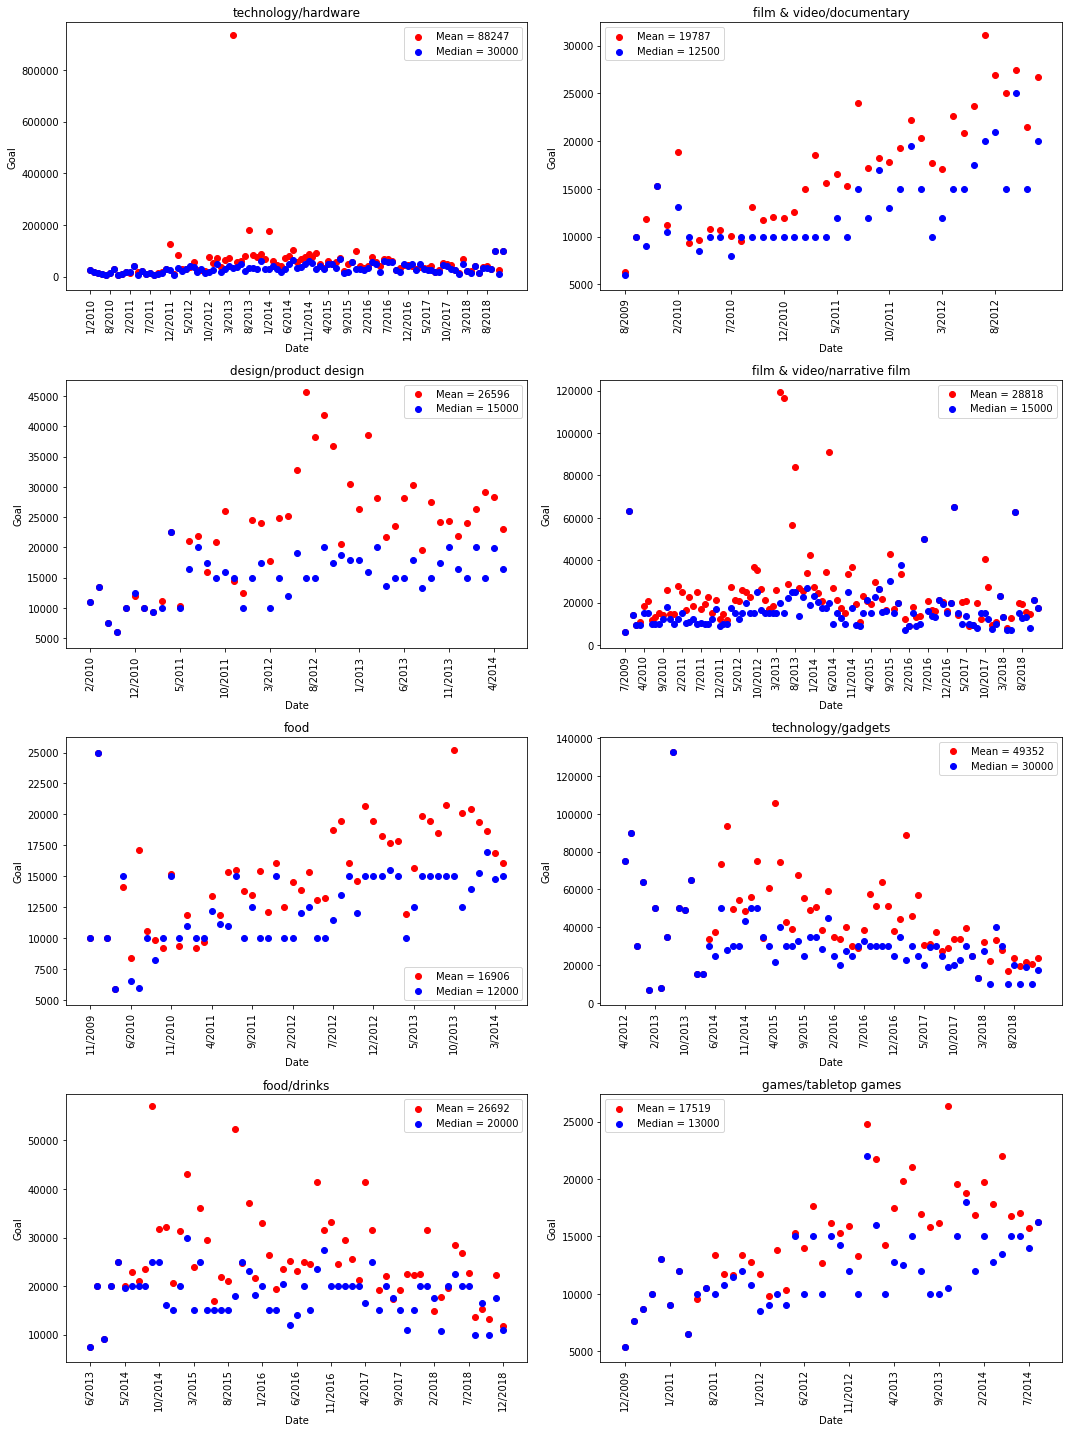

In [240]:
category_freq = df1['category_name'].value_counts().to_dict()

df4_1 = df1.copy()

fig = plt.figure(figsize=(15, 20))
count = 0
perc_diff = {}
for i in category_freq.keys():
    count += 1
    temp = df4_1.loc[df4_1['category_name'] == i]
    if len(temp) >= 950: # sufficient number of projects
        temp['Month/Year'] = temp['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
        new_dict = dict()
        for j in temp['Month/Year']:
            temp1 = temp.loc[temp['Month/Year'] == j]
            new_dict[j] = temp1['goal']

        avg_dict = {}
        median_dict = {}
        for k,v in new_dict.items():
            avg_dict[k] = sum(v)/ len(v)
            median_dict[k] = statistics.median(v)

        ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        ordered_df4_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        
        plt.subplot(4, 2, count)
        
        plt.scatter(*zip(*ordered_df4_1), color = 'red')
        plt.scatter(*zip(*ordered_df4_2), color = 'blue')
        locs, labs = plt.xticks() 
        plt.xticks(locs[0::5], rotation = 'vertical') 
        plt.xlabel('Date')
        plt.ylabel('Goal')
        mean = sum(temp['goal']) / len(temp['goal'])
        med = statistics.median(temp['goal'])
        plt.legend(['Mean = ' + str(round(mean)), 
                    'Median = ' + str(round(med))])
        plt.title(i)
        
        perc_diff[i] = (mean - med) / ((mean + med) / 2)
        
plt.tight_layout()

plt.savefig(path3 + 'Monthy_goal_size_frequent_categories.png')

print(perc_diff)

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


{'technology/hardware': 0.2961575037426912, 'film & video/documentary': 0.2961575037426912, 'design/product design': 0.2961575037426912, 'film & video/narrative film': 0.2961575037426912, 'food': 0.2961575037426912, 'technology/gadgets': 0.2961575037426912, 'food/drinks': 0.2961575037426912, 'games/tabletop games': 0.2961575037426912}


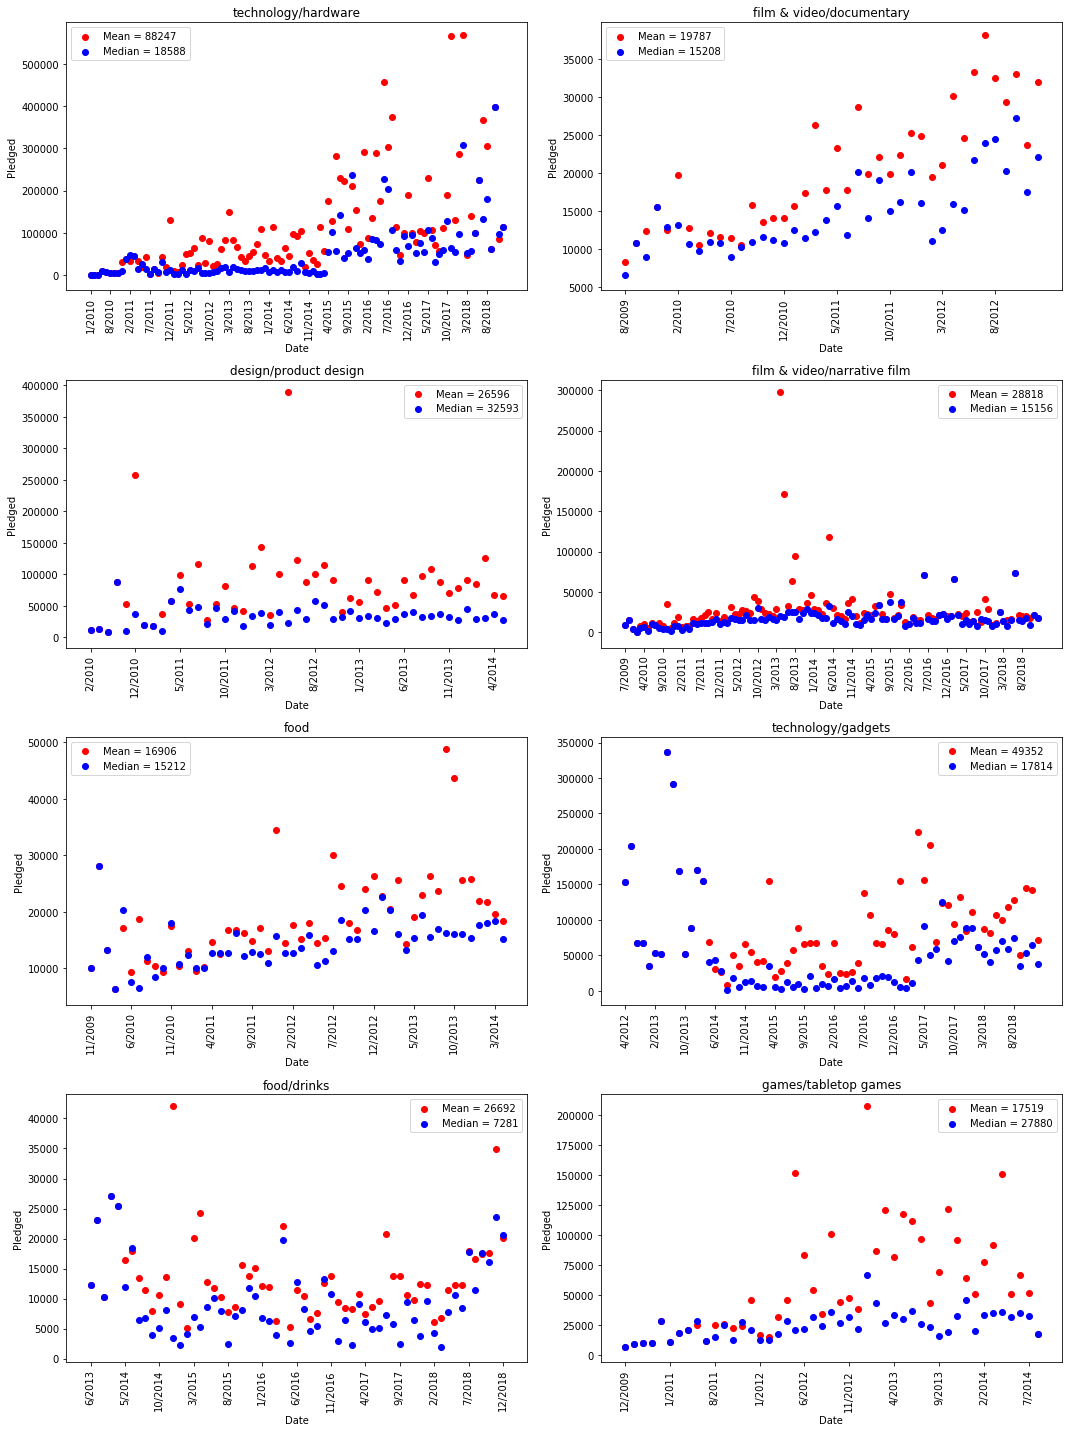

In [241]:
category_freq = df1['category_name'].value_counts().to_dict()

df4_1 = df1.copy()

fig = plt.figure(figsize=(15, 20))
count = 0
perc_diff = {}
for i in category_freq.keys():
    count += 1
    temp = df4_1.loc[df4_1['category_name'] == i]
    if len(temp) >= 950: # sufficient number of projects
        temp['Month/Year'] = temp['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
        new_dict = dict()
        for j in temp['Month/Year']:
            temp1 = temp.loc[temp['Month/Year'] == j]
            new_dict[j] = temp1['usd_pledged']

        avg_dict = {}
        median_dict = {}
        for k,v in new_dict.items():
            avg_dict[k] = sum(v)/ len(v)
            median_dict[k] = statistics.median(v)

        ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        ordered_df4_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        
        plt.subplot(4, 2, count)
        
        plt.scatter(*zip(*ordered_df4_1), color = 'red')
        plt.scatter(*zip(*ordered_df4_2), color = 'blue')
        locs, labs = plt.xticks() 
        plt.xticks(locs[0::5], rotation = 'vertical') 
        plt.xlabel('Date')
        plt.ylabel('Pledged')
        plt.legend(['Mean = ' + str(round(sum(temp['goal']) / len(temp['usd_pledged']))), 
                    'Median = ' + str(round(statistics.median(temp['usd_pledged'])))])
        plt.title(i)
        
        perc_diff[i] = (mean - med) / ((mean + med) / 2)
        
plt.tight_layout()

plt.savefig(path3 + 'Monthy_pledged_size_frequent_categories.png')

print(perc_diff)